In [2]:
from scipy import signal

In [3]:
import numpy as np

In [9]:
from PIL import Image

In [7]:
'''
微分を使ったエッジ特徴量の抽出
エッジ特徴量：画像内で輝度の変化が大きい部分、物体の輪郭抽出
１次微分フィルタ：隣接する画素との画素値は離散的に変化するので正確に微分を計算できない→カーネルと畳み込み演算
２次微分の特徴量抽出（ラプラシアンフィルタ）：輝度が一定に変化している部分を除外
'''

def generate_kernel():
    kernel_x = np.zeros((3,3))
    kernel_y = np.zeros((3,3))
    kernel_lap = np.zeros((3,3))

    kernel_x[1,1], kernel_x[1,2] = -1, 1
    kernel_y[1,1], kernel_y[2,1] = -1, 1
    kernel_lap[0,1] = kernel_lap[1,0] = kernel_lap[1,2] = kernel_lap[2,1] = 1
    kernel_lap[1,1] = -4

    return kernel_x, kernel_y, kernel_lap

In [8]:
kernel_x, kernel_y, kernel_lap = generate_kernel()
print("水平方向の１次微分カーネル")
print(kernel_x)
print("垂直方向の１次微分カーネル")
print(kernel_y)
print("ラプラシアンフィルタのカーネル")
print(kernel_lap)

水平方向の１次微分カーネル
[[ 0.  0.  0.]
 [ 0. -1.  1.]
 [ 0.  0.  0.]]
垂直方向の１次微分カーネル
[[ 0.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  1.  0.]]
ラプラシアンフィルタのカーネル
[[ 0.  1.  0.]
 [ 1. -4.  1.]
 [ 0.  1.  0.]]


In [23]:
img = Image.open('drive/MyDrive/python_image_recognition/data/coffee.jpg')
img = np.asarray(img, dtype='int32')

img_x_diff = np.absolute(signal.convolve2d(img, kernel_x, mode='same'))
img_y_diff = np.absolute(signal.convolve2d(img, kernel_y, mode='same'))
# 水平方向と垂直方向のエッジ特徴量を合成
img_diff = np.sqrt(img_x_diff**2+img_y_diff**2)

img_lap_diff = signal.convolve2d(img, kernel_lap, mode='same')

In [25]:
# 範囲を超えた画素値をクリップ
img_x_diff = np.clip(img_x_diff, 0, 255).astype('uint8')
img_y_diff = np.clip(img_y_diff, 0, 255).astype('uint8')
img_diff = np.clip(img_diff, 0, 255).astype('uint8')
img_lap = np.clip(img_lap_diff, 0, 255).astype('uint8')

水平方向


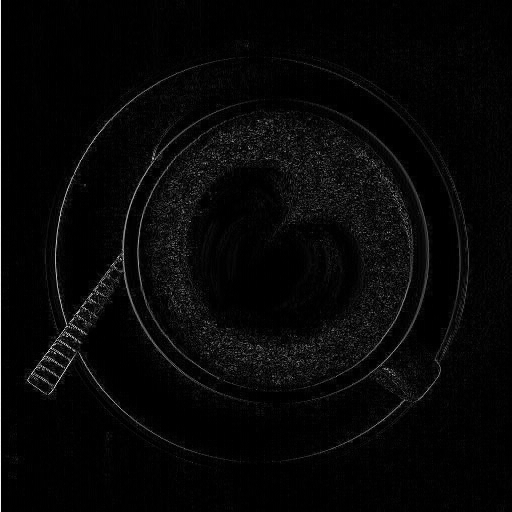

垂直方向


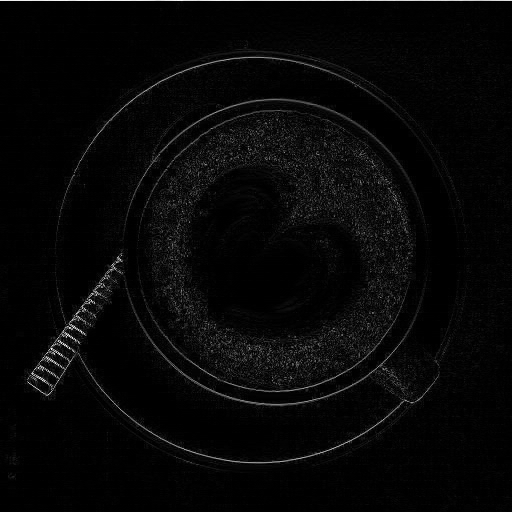

両方向


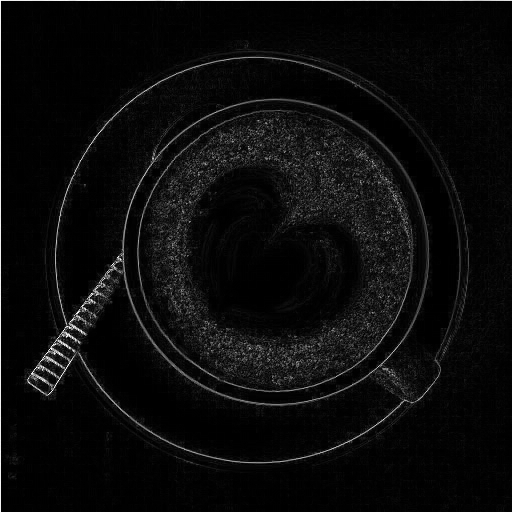

ラプラシアン


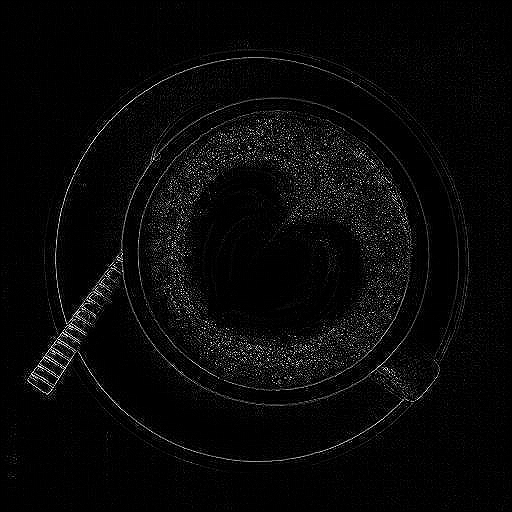

In [26]:
img_x_diff = Image.fromarray(img_x_diff)
img_y_diff = Image.fromarray(img_y_diff)
img_diff = Image.fromarray(img_diff)
img_lap = Image.fromarray(img_lap)

print("水平方向")
display(img_x_diff)

print("垂直方向")
display(img_y_diff)

print("両方向")
display(img_diff)

print("ラプラシアン")
display(img_lap)

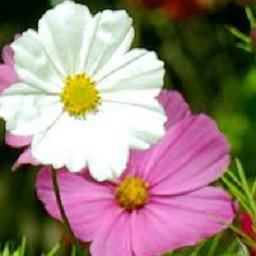

In [37]:
img = Image.open('drive/MyDrive/python_image_recognition/data/cosmos.jpg')
display(img)

In [35]:
'''
attention
attentionの特徴：画像のどの部分から特徴を抽出するかを動的に決定する点

畳み込み演算：カーネルを準備する必要がある
attention：クエリという特長収集用のベクトルを用意（入力画像の色に合わせてクエリを生成することができる

attentionの計算
画像の各画像に対して重み行列をかけて画像を特徴空間に射映する
特長量とクエリの内積を取り、ソフトマックスを計算したもの
'''
img = Image.open('drive/MyDrive/python_image_recognition/data/cosmos.jpg')
img = np.asarray(img, dtype='float32')

# 白のコスモスとピンクのコスモスに対して大きいアテンションの値が得られるような重み
w = np.array([
    [0.0065, -0.0045, -0.0018, 0.0075, 0.0095, 0.0075, -0.0026, 0.0022],
    [-0.0065, 0.0081, 0.0097, -0.0070, -0.0086, -0.0107, 0.0062, -0.0050],
    [0.0024, -0.0018, 0.0002, 0.0023, 0.0017, 0.0021, -0.0017, 0.0016],
])

features = np.matmul(img, w) # 画像を特長空間に射映、RGBの3チャネルを8チャネルに変換

# クエリ
feature_white = features[50,50]
feature_pink = features[200, 200]

In [36]:
# ソフトマックスへの入力（クエリと特徴量の内積）
atten_white = np.matmul(features, feature_white)
atten_pink = np.matmul(features, feature_pink)

# ソフトマックス（＝attentionの計算）
atten_white = np.exp(atten_white)/np.sum(np.exp(atten_white))
atten_pink = np.exp(atten_pink)/np.sum(np.exp(atten_pink))

In [40]:
# 正規化
atten_white = (atten_white-np.amin(atten_white))/(np.amax(atten_white)-np.amin(atten_white))
atten_pink = (atten_pink-np.amin(atten_pink))/(np.amax(atten_pink)-np.amin(atten_pink))

# 表示
img_atten_white = Image.fromarray((atten_white*255).astype('uint8'))
img_atten_pink = Image.fromarray((atten_pink*255).astype('uint8'))

白コスモス


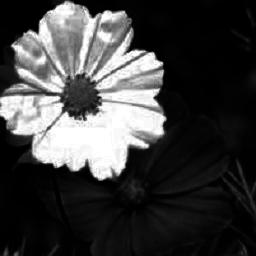

ピンクコスモス


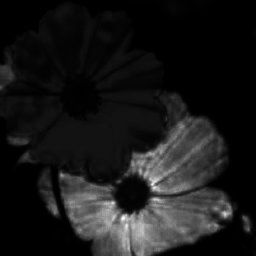

In [41]:
print('白コスモス')
display(img_atten_white)
print('ピンクコスモス')
display(img_atten_pink)